## **Testing Frontier Models' Performance before training on the prices dataset!**
And now - we put Frontier Models to the test.  

2 important points:  
* It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

* It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

### **When used some frontier models for prediction wothout any training, I got these Mean Absolute Prediction Errors :**

On the Appliances only test dataset: (250 items only)
* GPT-4o-Mini - $20
* GPT-4o - $17

On the whole test dataset: (250 items only)  
* GPT-4o-Mini - $80
* GPT-4o - $73

While the Tradional Machine Learning Techniques could only get Mean Absolute Prediction Error of $97 as highest..!! (after training on all 400,000 training samples)

In [1]:

# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

In [2]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# from our modules
# # moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)


from items import Item
from testing import Tester

In [4]:
load_dotenv(override=True)

True

In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [26]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

### Before we look at the frontier  
There is one more model we could consider. 

> Label the dataset yourself (make predictions about the price) and then test how well you did? 

In [14]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [ ]:

# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [ ]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

In [ ]:
Tester.test(human_pricer, test)

### **First the humble but mighty GPT-4o-Mini**  
It's called Mini, but it packs a punch!!

In [27]:
# First let's work on a good prompt for a frontier model
# Notice that I am removing " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible
# but a frontier model needs no such simplification

def messages_for(item):
    system_message = "You estimate the price of items. Reply only with the price, no explanation."
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {'role': 'system', 'content': system_message}, 
        {'role': 'user', 'content': user_prompt}, 
        {'role': 'assistant', 'content': 'Price is $'}
    ]

In [28]:
# try this out!!

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate the price of items. Reply only with the price, no explanation.'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [29]:
# A utility to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [30]:
# In case gpt-4o-mini doesn't obey my instructions:

get_price("The price is roughly $99.99 because blah blah..!!")

99.99

In [31]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model='gpt-4o-mini', 
        messages = messages_for(item), 
        seed=42, 
        max_tokens=5      
    )

    reply = response.choices[0].message.content
    return get_price(reply)

In [32]:
# trying out

gpt_4o_mini(test[0]), test[0].price   # almost there!!

(239.99, 374.41)

1: Guess: $239.99 Truth: $374.41 Error: $134.42 SLE: 0.20 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $47.99 Truth: $61.68 Error: $13.69 SLE: 0.06 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $499.99 Truth: $599.99 Error: $100.00 SLE: 0.03 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $19.99 Truth: $16.99 Error: $3.00 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $25.99 Truth: $31.99 Error: $6.00 SLE: 0.04 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $47.99 Truth: $101.79 Error: $53.80 SLE: 0.55 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $349.00 Truth: $289.00 Error: $60.00 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $39.99 Truth: $65.99 Error: $26.00 SLE: 0.24 It

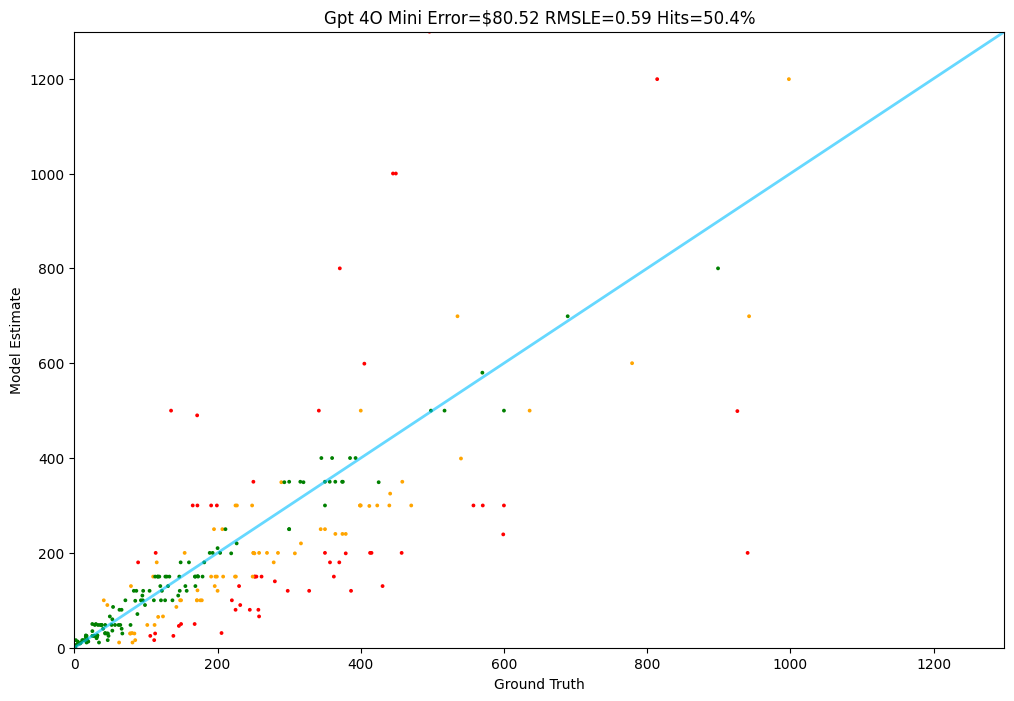

In [ ]:
# Testing finally !

# NOTE: This testing is for the 'test.pkl' not 'test_lite.pkl'

Tester.test(gpt_4o_mini, test)

# NOTE: When I ran this for 'test_lite.pkl', I already got a Mean Absolute Prediction Error of $20 already!! (test_lite.pkl has only the applicances data)


In [24]:
# The function for gpt-4o-frontier

def gpt_4o_frontier(item):
    reponse = openai.chat.completions.create(
        model='gpt-4o',
        messages=messages_for(item), 
        seed=42, 
        max_tokens=5
    )

    reply = reponse.choices[0].message.content
    return get_price(reply)

1: Guess: $260.00 Truth: $374.41 Error: $114.41 SLE: 0.13 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $100.00 Truth: $225.11 Error: $125.11 SLE: 0.65 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $47.00 Truth: $61.68 Error: $14.68 SLE: 0.07 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $390.00 Truth: $599.99 Error: $209.99 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.00 Truth: $16.99 Error: $1.99 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $80.00 Truth: $101.79 Error: $21.79 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $500.00 Truth: $635.86 Error: $135.86 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 

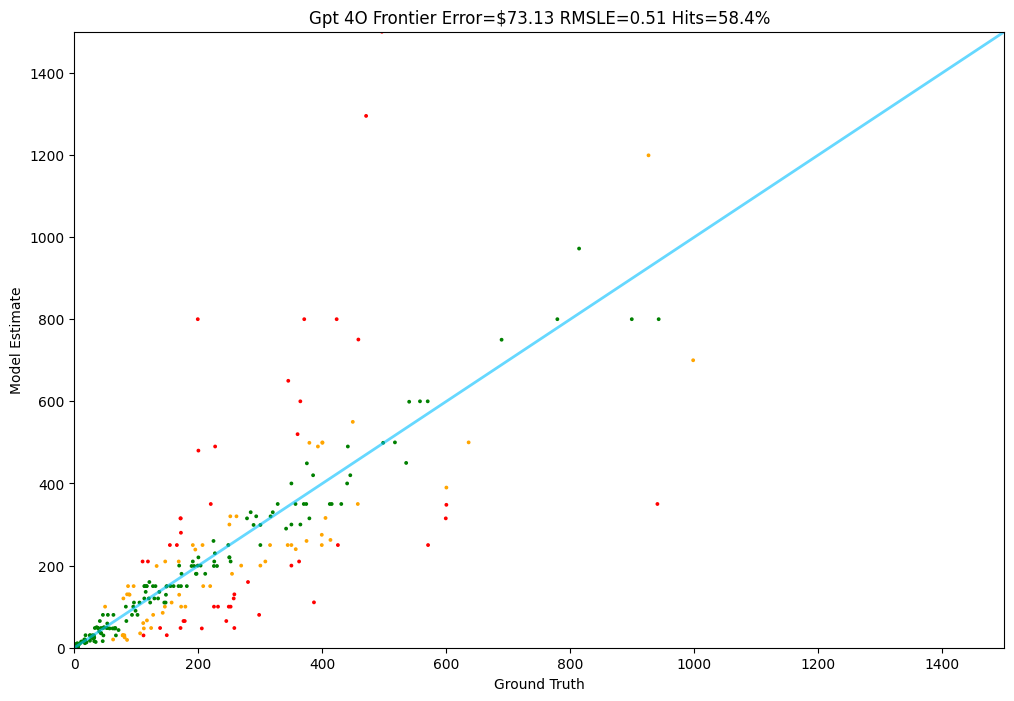

In [35]:
# Testing out

# NOTE: When I ran this for 'test_lite.pkl', I already got a Mean Absolute Prediction Error of $17 already!! (test_lite.pkl has only the applicances data)

Tester.test(gpt_4o_frontier, test)